# Obtaining 3D trajectory from accelerometer data  

This article shows how to track the trajectory of a smartphone in 3D space. The data for this was downloaded using the App AndroSensor for Android (outputs are set to SI units, recording interval is set to 0.01 seconds (100Hz), and the delimiter in the CSV file format is “ , ”). 

Think of a phone maneuver that you would like to track in 3D (for simplicity, I suggest moving up and down for 2 seconds), and when ready - press record and stop. Export the CSV with the built in email export, or find the AndroSensor folder in your phone directory and manually export the CSV.

The steps involved are:
- Gather some experimental motion data
- Open the .csv file with Pandas to examine data steams.
- Transform the x,y,z accelerations from the IMU to an inertial Earth frame.
- Double integrate the Earth frame accelerations with respect to time to calculate the x,y,z positions of the phone.
- Make a 3D plot of the phone’s trajectory, and observe the motion drift from the accelerometer.
- Perform a Fourier analysis of the acceleration signals to examine the noise spectrum in each accelerometer axis.
- Create a high-pass filter to attenuate low frequency noise, and perform an inverse Fourier transform to calculate new accelerations with less noise.
- Make a 3D plot trajectory, and add x,y,z axis vectors to indicate the phone’s pose.

Now we will open the CSV in Python, and plot the data-streams for our experiment (Fig. 4).


In [1]:
# import modules
import pandas as pd
import numpy as np
from scipy.integrate import cumtrapz
from numpy import sin,cos,pi

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib
import mpld3

# matplotlib.style.use('ggplot')
%matplotlib notebook
mpld3.enable_notebook()

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# import data from CSV
# df = pd.read_csv('Data/Lift 1m.csv',encoding = "utf-8")
df = pd.read_csv('data/3D-Trajectory-Data/Lift 1m.csv')


<IPython.core.display.Javascript object>


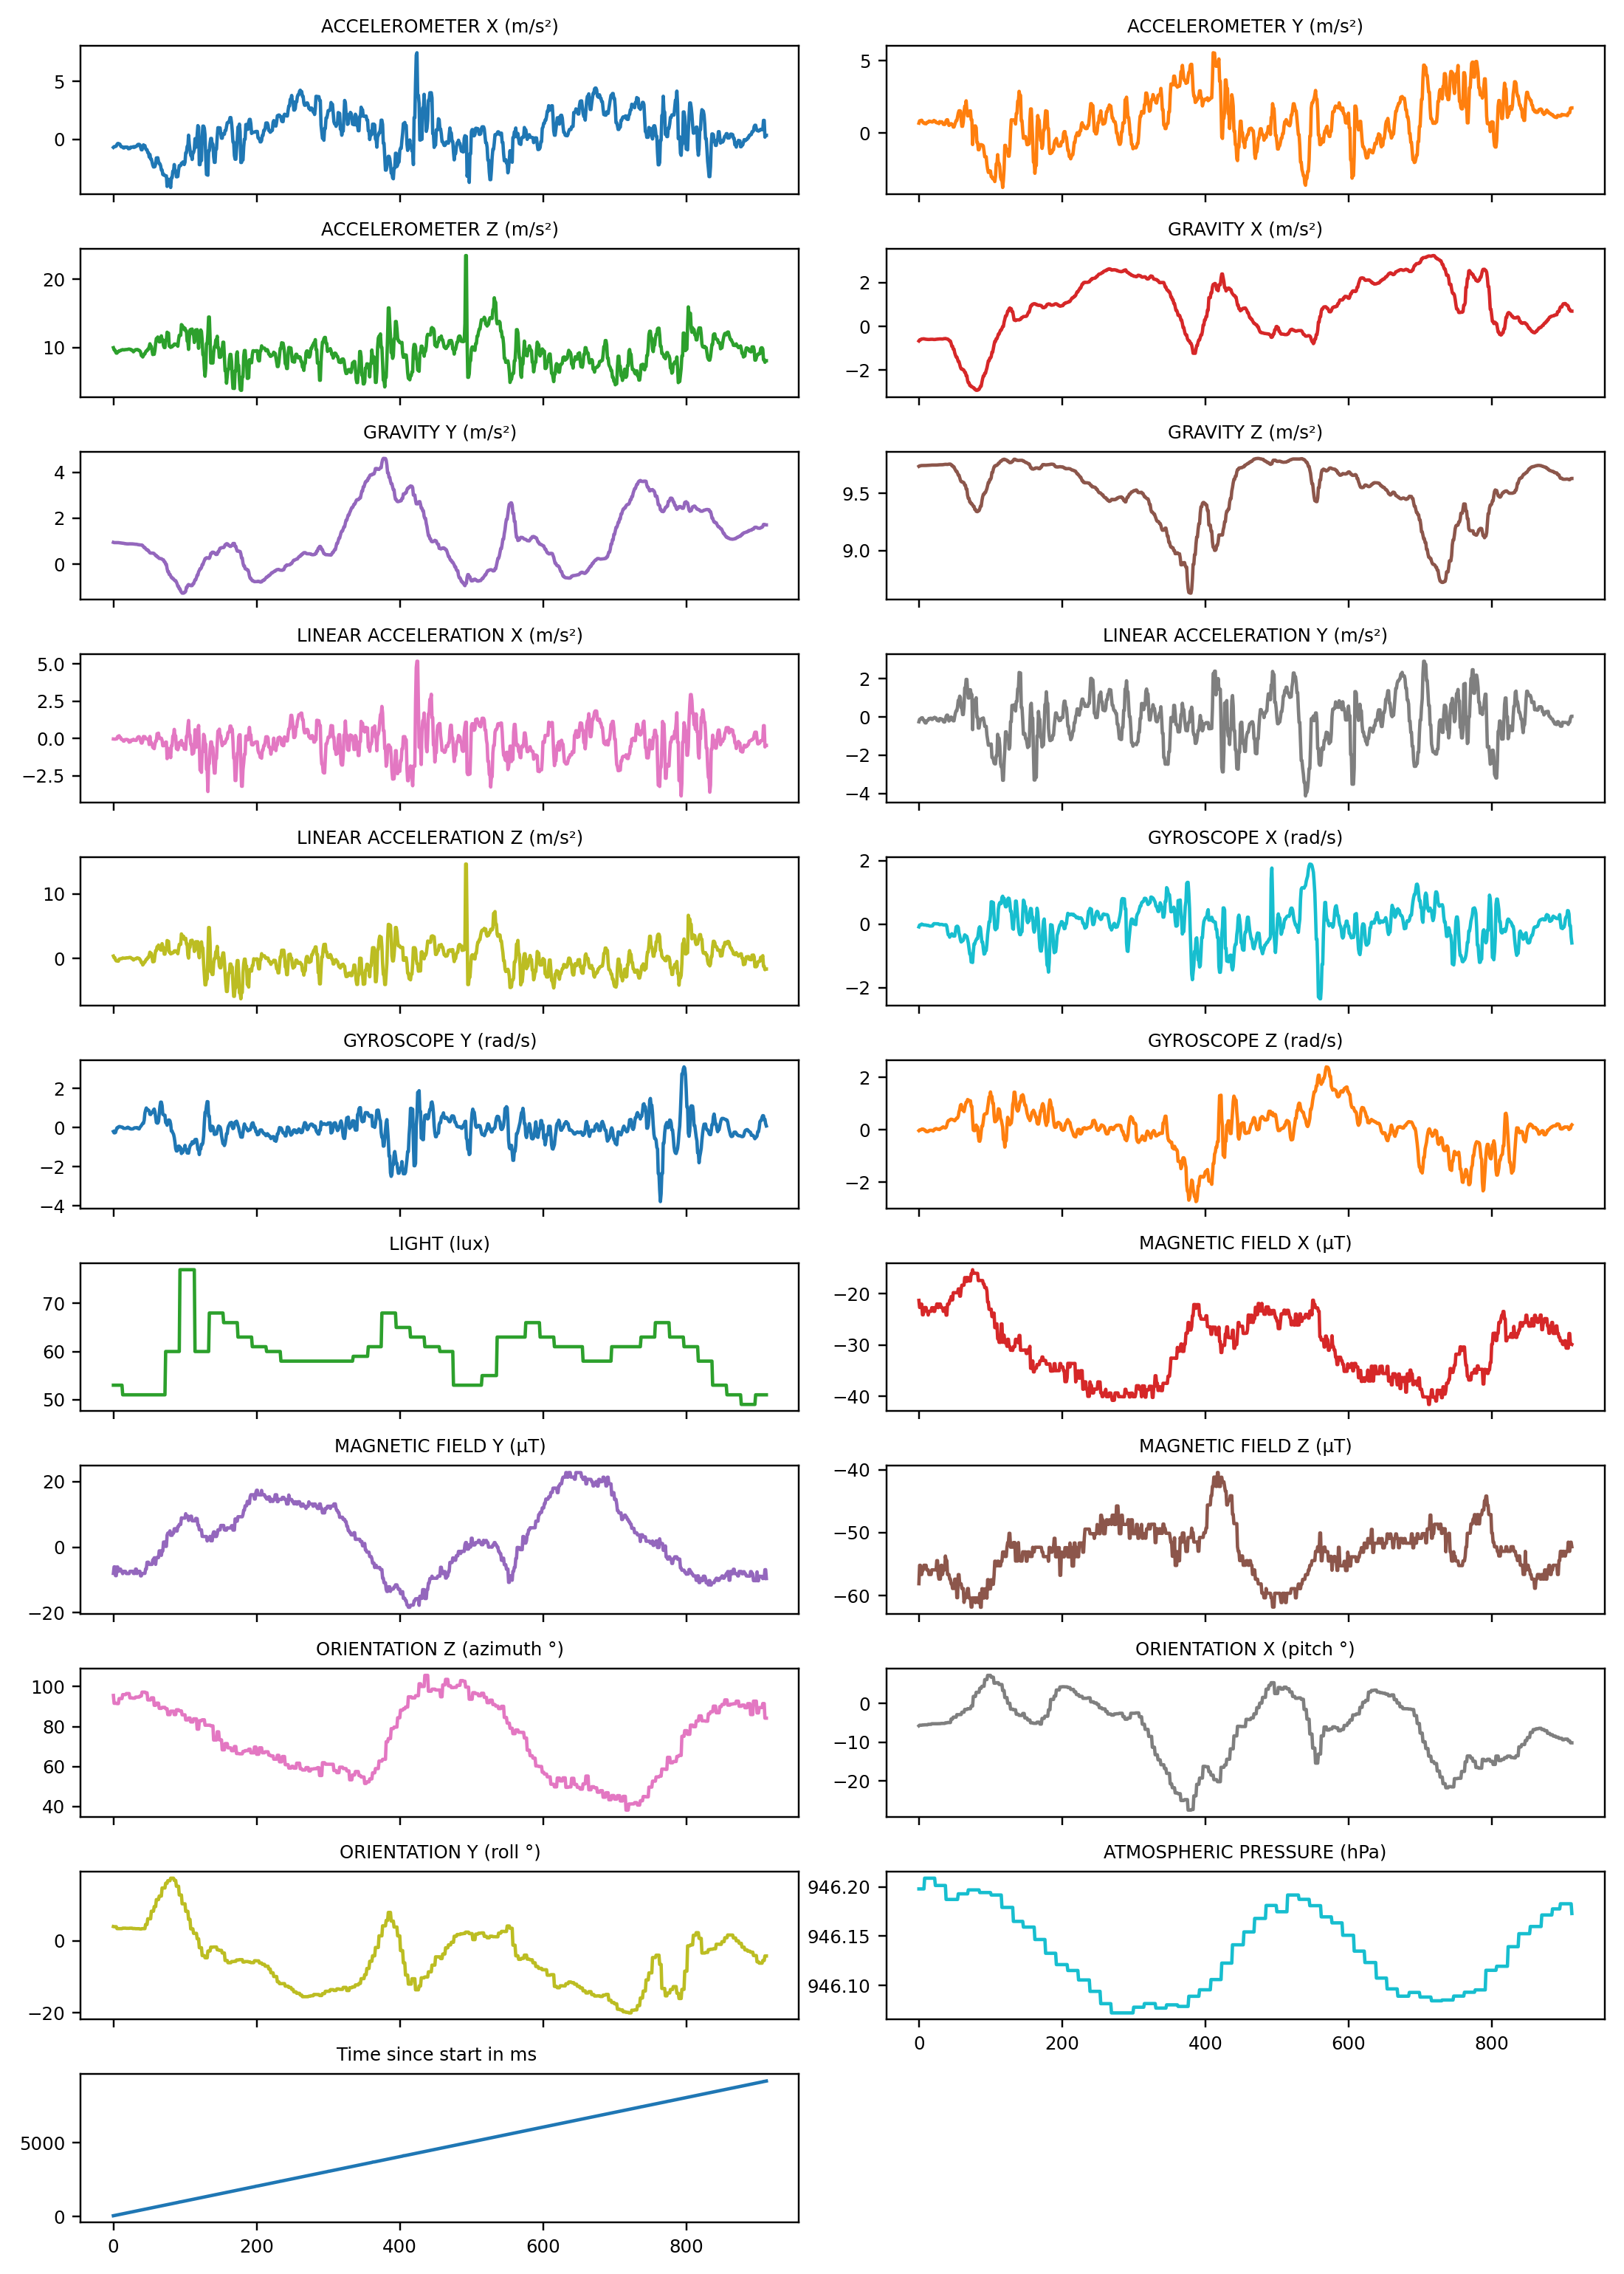

In [2]:
# Take a look at all sensor outputs

plt.rcParams['figure.figsize'] = [10,14]

df.plot(subplots=True,sharex=True,layout=(11,2),title=list(df.columns[:-1]),legend=False)
plt.tight_layout()
# plt.show()

## Body to earth frame conversion

The phone’s accelerometer measures acceleration in reference to itself (the body frame) and we need to transform the body frame accelerations to an inertial, non-rotating frame ( the earth frame). This will make it possible to hold the phone in any orientation, and measure the correct acceleration vectors to calculate the phone’s trajectory in the earth frame.

![title](figures/body-frame-vs-earth-frame.jpg)

The transformation is done with matrix algebra as shown below, where [X,Y,Z] are the body frame linear accelerations, and Rz,Ry,Rx are the rotation matrices for each axis in order to rotate the [X,Y,Z] over to earth’s [x,y,z] axes. The Euler angles, (ψ, θ, φ) correspond to the angles about the x,y,z, axes or pitch, roll, and yaw.

![title](figures/rotation-matrix.png)

<IPython.core.display.Javascript object>


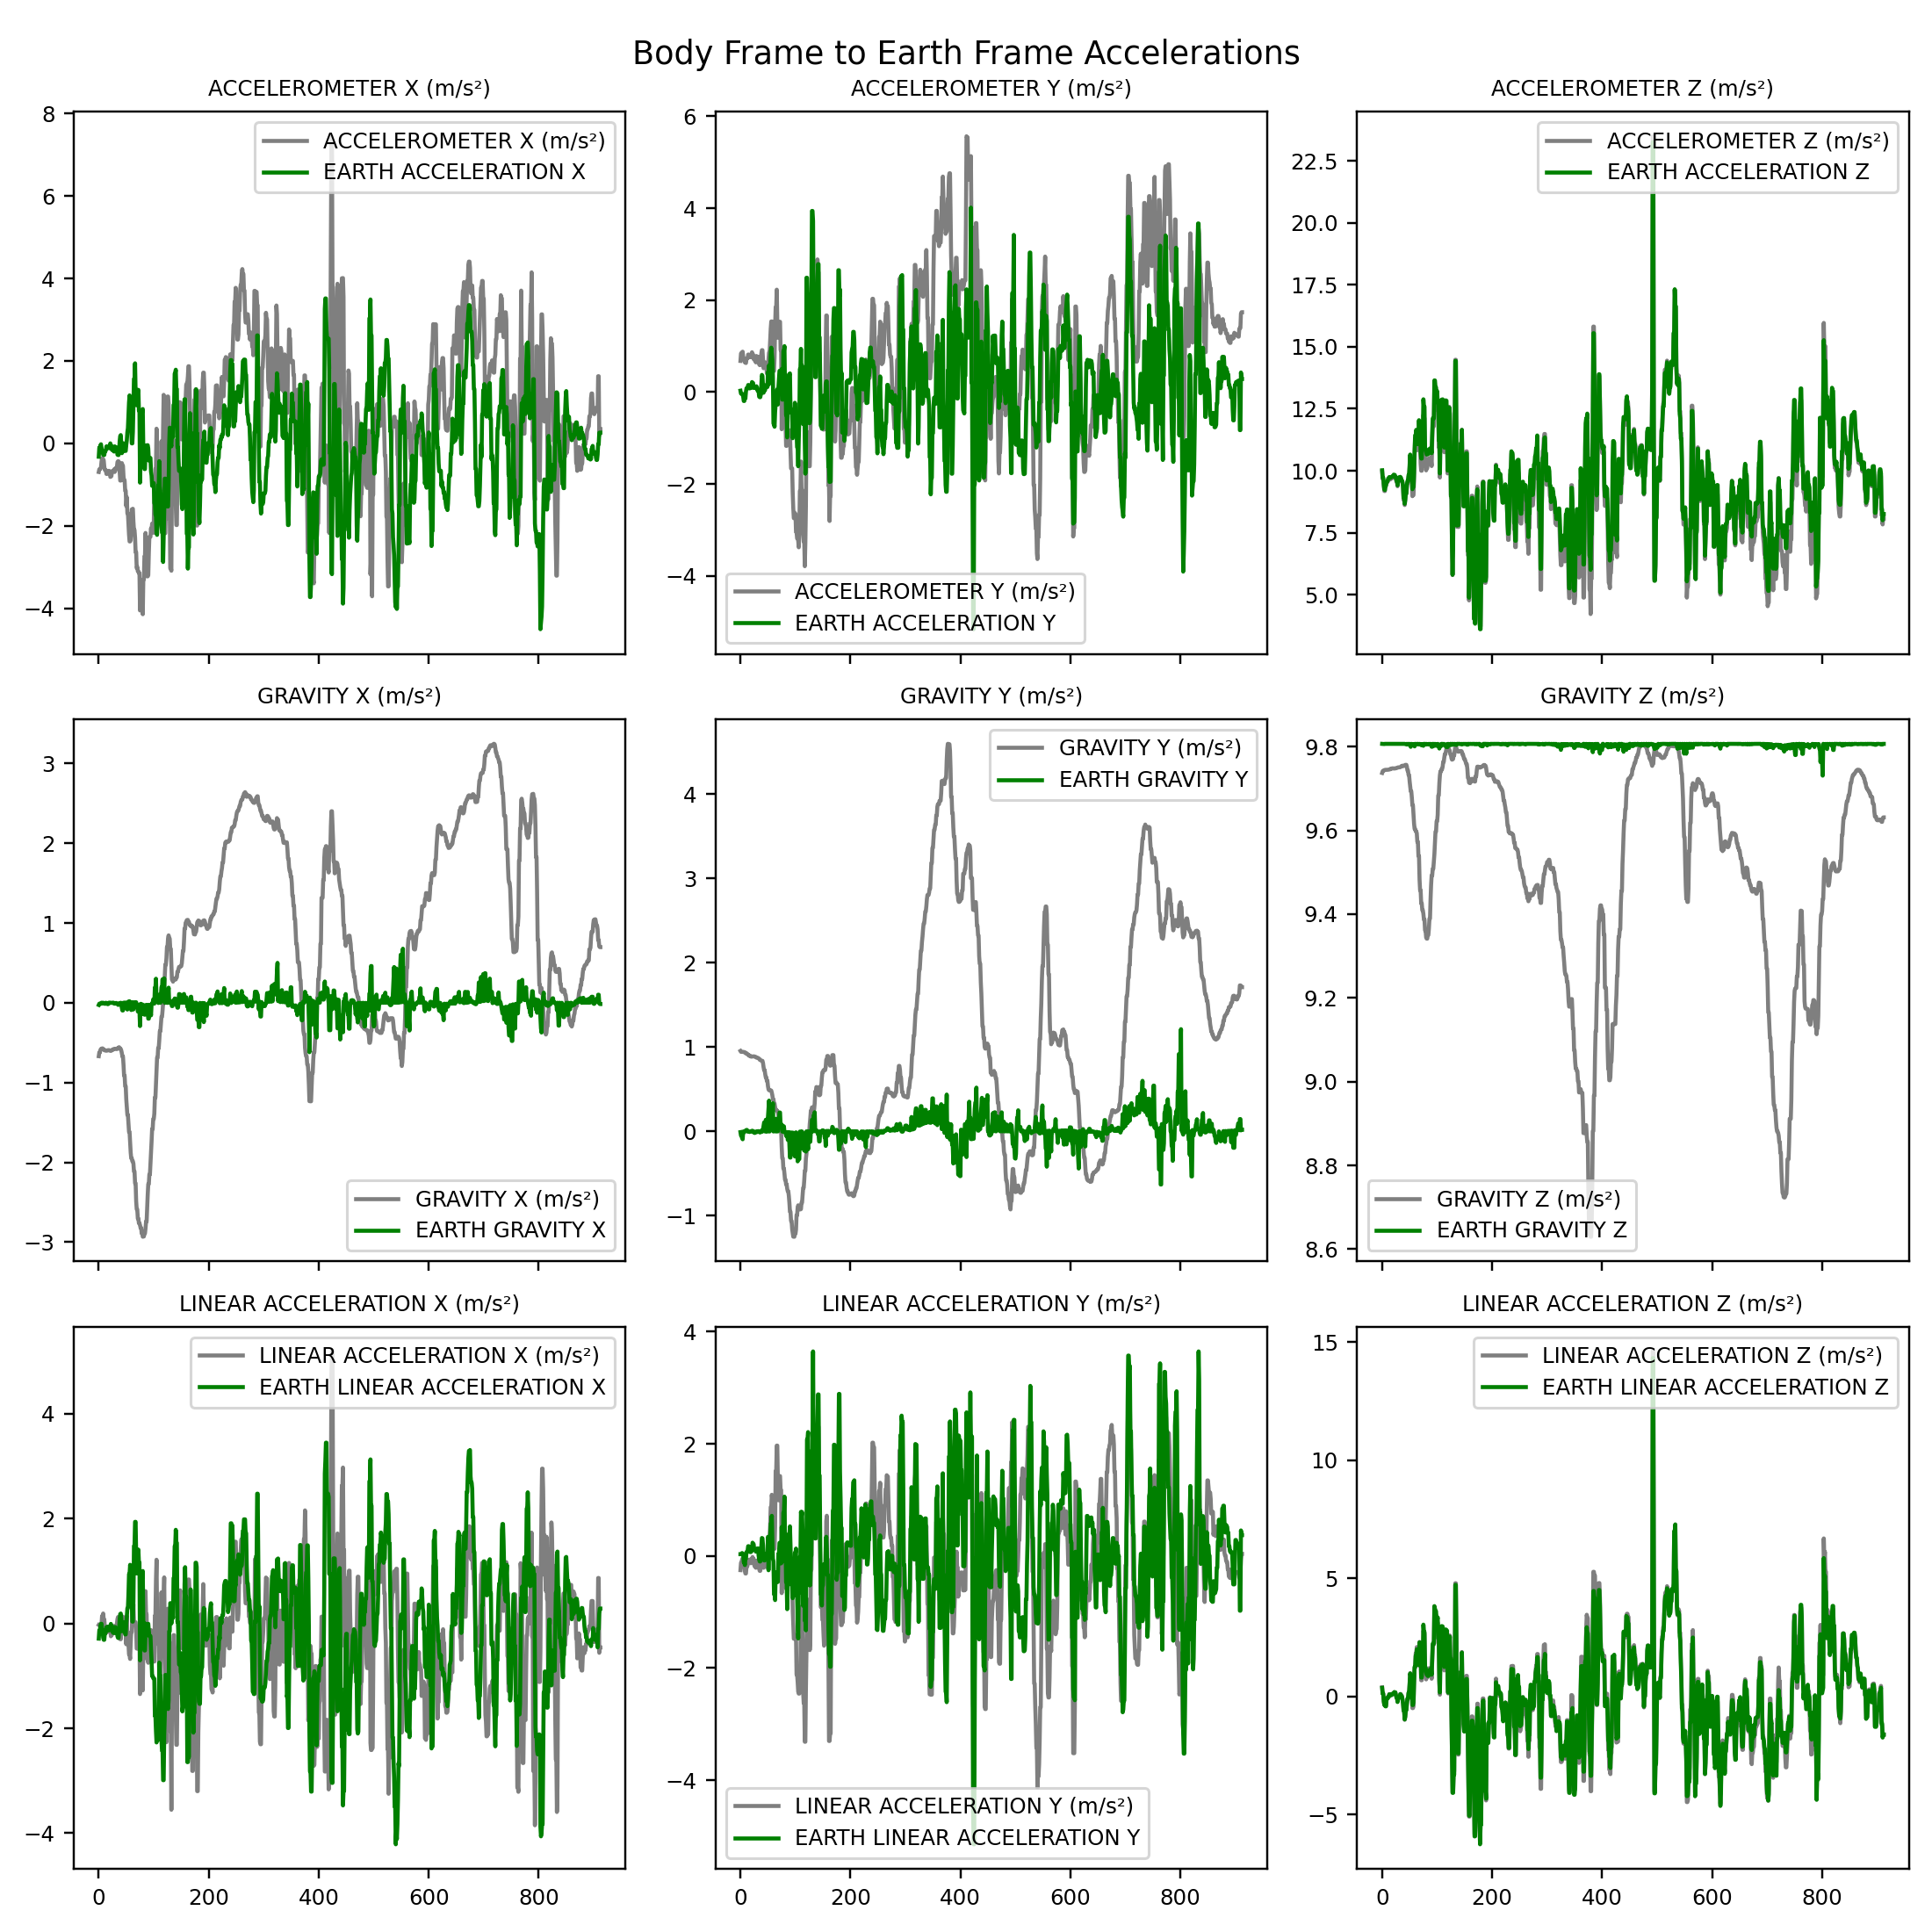

In [3]:
dt = 0.01 # Sampling at 100Hz
# Convert orientation units to radians
cols_angles = ['ORIENTATION X (pitch °)','ORIENTATION Y (roll °)','ORIENTATION Z (azimuth °)']

for axis in cols_angles:
    df[axis] = df[axis] * pi/180

# Transform body frame accelerations into the inertial (Earth) frame
    # Rotation matrices
def R_x(x):
    # body frame rotation about x axis
    return np.array([[1,      0,       0],
                     [0,cos(-x),-sin(-x)],
                     [0,sin(-x), cos(-x)]])

def R_y(y):
    # body frame rotation about y axis
    return np.array([[cos(-y),0,-sin(-y)],
                    [0,      1,        0],
                    [sin(-y), 0, cos(-y)]])

def R_z(z):
    # body frame rotation about z axis
    return np.array([[cos(-z),-sin(-z),0],
                     [sin(-z), cos(-z),0],
                     [0,      0,       1]])

# Set up arrays to hold acceleration data for transfromation
accel = np.array([df['ACCELEROMETER X (m/s²)'],
                  df['ACCELEROMETER Y (m/s²)'],
                  df['ACCELEROMETER Z (m/s²)']])
grav = np.array([df['GRAVITY X (m/s²)'],
                 df['GRAVITY Y (m/s²)'],
                 df['GRAVITY Z (m/s²)']])
line = np.array([df['LINEAR ACCELERATION X (m/s²)'],
                 df['LINEAR ACCELERATION Y (m/s²)'],
                 df['LINEAR ACCELERATION Z (m/s²)']])

# Set up arrays to hold euler angles for rotation matrices
pitch = df['ORIENTATION X (pitch °)']
roll = df['ORIENTATION Y (roll °)']
yaw = df['ORIENTATION Z (azimuth °)']

# Initilize arrays for new transformed accelerations
earth_accels = np.empty(accel.shape)
earth_gravity = np.empty(accel.shape)
earth_linear = np.empty(accel.shape)

# Perform frame transformations (body frame --> earth frame) 
for i in range(df.shape[0]):
    # accel_earth = (RzRyRx)(accel_body)
    earth_accels[:,i] = R_z(yaw[i]) @ R_y(roll[i]) @ R_x(pitch[i]) @ accel[:,i]
    earth_gravity[:,i] = R_z(yaw[i]) @ R_y(roll[i]) @ R_x(pitch[i]) @ grav[:,i]
    earth_linear[:,i] = R_z(yaw[i]) @ R_y(roll[i]) @ R_x(pitch[i]) @ line[:,i]
        
# Create new columns in dataframe for earth frame accelerations    
df['EARTH ACCELERATION X'] = earth_accels[0,:]
df['EARTH ACCELERATION Y'] = earth_accels[1,:]
df['EARTH ACCELERATION Z'] = earth_accels[2,:]
df['EARTH GRAVITY X'] = earth_gravity[0,:]
df['EARTH GRAVITY Y'] = earth_gravity[1,:]
df['EARTH GRAVITY Z'] = earth_gravity[2,:]
df['EARTH LINEAR ACCELERATION X'] = earth_linear[0,:]
df['EARTH LINEAR ACCELERATION Y'] = earth_linear[1,:]
df['EARTH LINEAR ACCELERATION Z'] = earth_linear[2,:]

# Plot new accelerations
cols_earth = ['EARTH ACCELERATION X','EARTH ACCELERATION Y',
              'EARTH ACCELERATION Z','EARTH GRAVITY X','EARTH GRAVITY Y',
              'EARTH GRAVITY Z','EARTH LINEAR ACCELERATION X',
              'EARTH LINEAR ACCELERATION Y','EARTH LINEAR ACCELERATION Z']
cols_body = ['ACCELEROMETER X (m/s²)','ACCELEROMETER Y (m/s²)',
             'ACCELEROMETER Z (m/s²)', 'GRAVITY X (m/s²)', 'GRAVITY Y (m/s²)',
             'GRAVITY Z (m/s²)', 'LINEAR ACCELERATION X (m/s²)',
             'LINEAR ACCELERATION Y (m/s²)', 'LINEAR ACCELERATION Z (m/s²)',]

plt.rcParams['figure.figsize'] = [10,10]
bodyplot = df.plot(y=cols_body,subplots=True,sharex=True,layout=(3,3),title=cols_body,style='k',alpha=0.5)
df.plot(y=cols_earth,subplots=True,ax=bodyplot,style='g',title='Body Frame to Earth Frame Accelerations')
plt.tight_layout()

# plt.show()

## Double integrate the earth frame accelerations

Let us see how to convert body frame to earth frame. The transformation is done with matrix algebra as shown in Fig. 7, where [X,Y,Z] are the body frame linear accelerations, and Rz,Ry,Rx are the rotation matrices for each axis in order to rotate the [X,Y,Z] over to earth’s [x,y,z] axes. The Euler angles, (ψ, θ, φ) correspond to the angles about the x,y,z, axes or pitch, roll, and yaw.

Next we will calculate the phone’s motion by integrating the linear accelerations and plot the results.

<img src="figures/double-integration.png" alt="Drawing" style="width: 350px;"/>

<IPython.core.display.Javascript object>


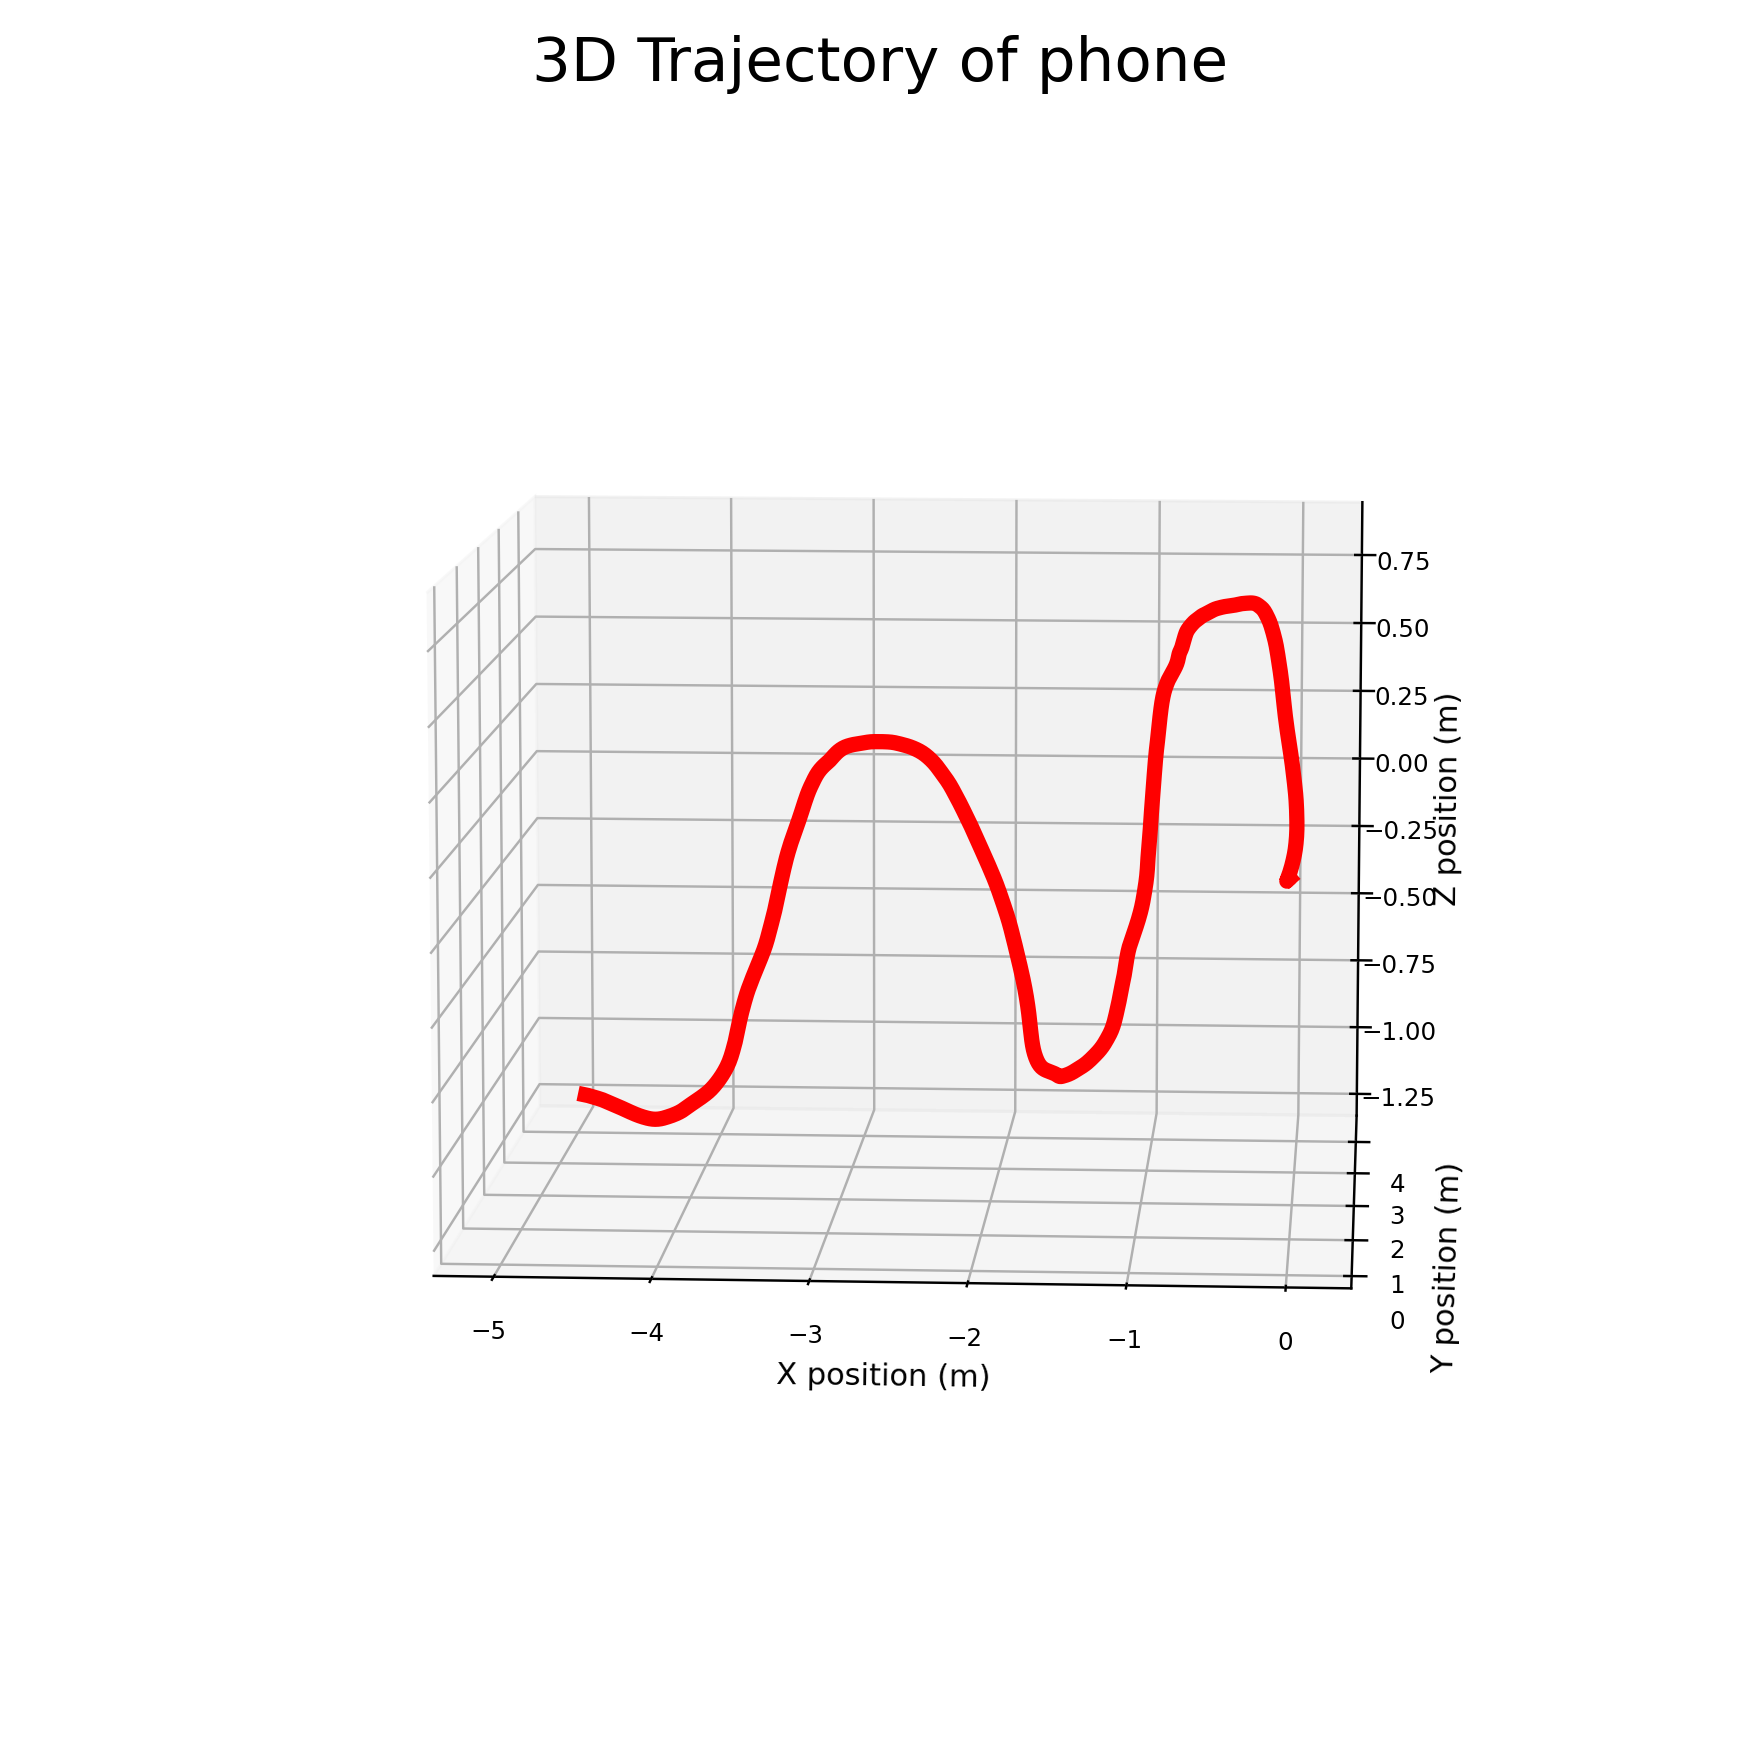

Text(0.5, 0, 'Z position (m)')

In [4]:
# Double integrate accelerations to find positions
x = cumtrapz(cumtrapz(df['EARTH LINEAR ACCELERATION X'],dx=dt),dx=dt)
y = cumtrapz(cumtrapz(df['EARTH LINEAR ACCELERATION Y'],dx=dt),dx=dt)
z = cumtrapz(cumtrapz(df['EARTH LINEAR ACCELERATION Z'],dx=dt),dx=dt)

# Plot 3D Trajectory
plt.rcParams['figure.figsize'] = [8,8]
plt.tight_layout()
fig3,ax = plt.subplots()
fig3.suptitle('3D Trajectory of phone',fontsize=20)
ax = plt.axes(projection='3d')
ax.plot3D(x,y,z,c='red',lw=5,label='phone trajectory')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')
#plt.show()


For this motion, I raised and lowered my phone without it moving much in the X or Y direction — yet the trajectory shows that I moved over 5 m away from my starting point! What gives?

## Performing a Fourier analysis of the acceleration measurements

The MEMS accelerometer in your phone is pretty cheap, and thus prone to generating a lot of noise. When we integrate the accelerations, we also integrate the noise — which causes a drift in the calculated trajectory. Most of the noise is usually at a low frequency, so it is possible to use a high-pass filter to attenuate the signal below this frequency. To determine the cutoff frequency, lets do a Fourier analysis of the noise spectrum and plot the results.

For each axis, we see that that there is quite a bit of noise below 10Hz. When designing the high-pass filter, we need to be careful to not attenuate frequencies that contain information about the movement of the phone. For Example, there is a large spike around 1Hz in the Z axis, and this might correspond to movement of the phone since I was moving it up and down at around 1Hz.

<IPython.core.display.Javascript object>


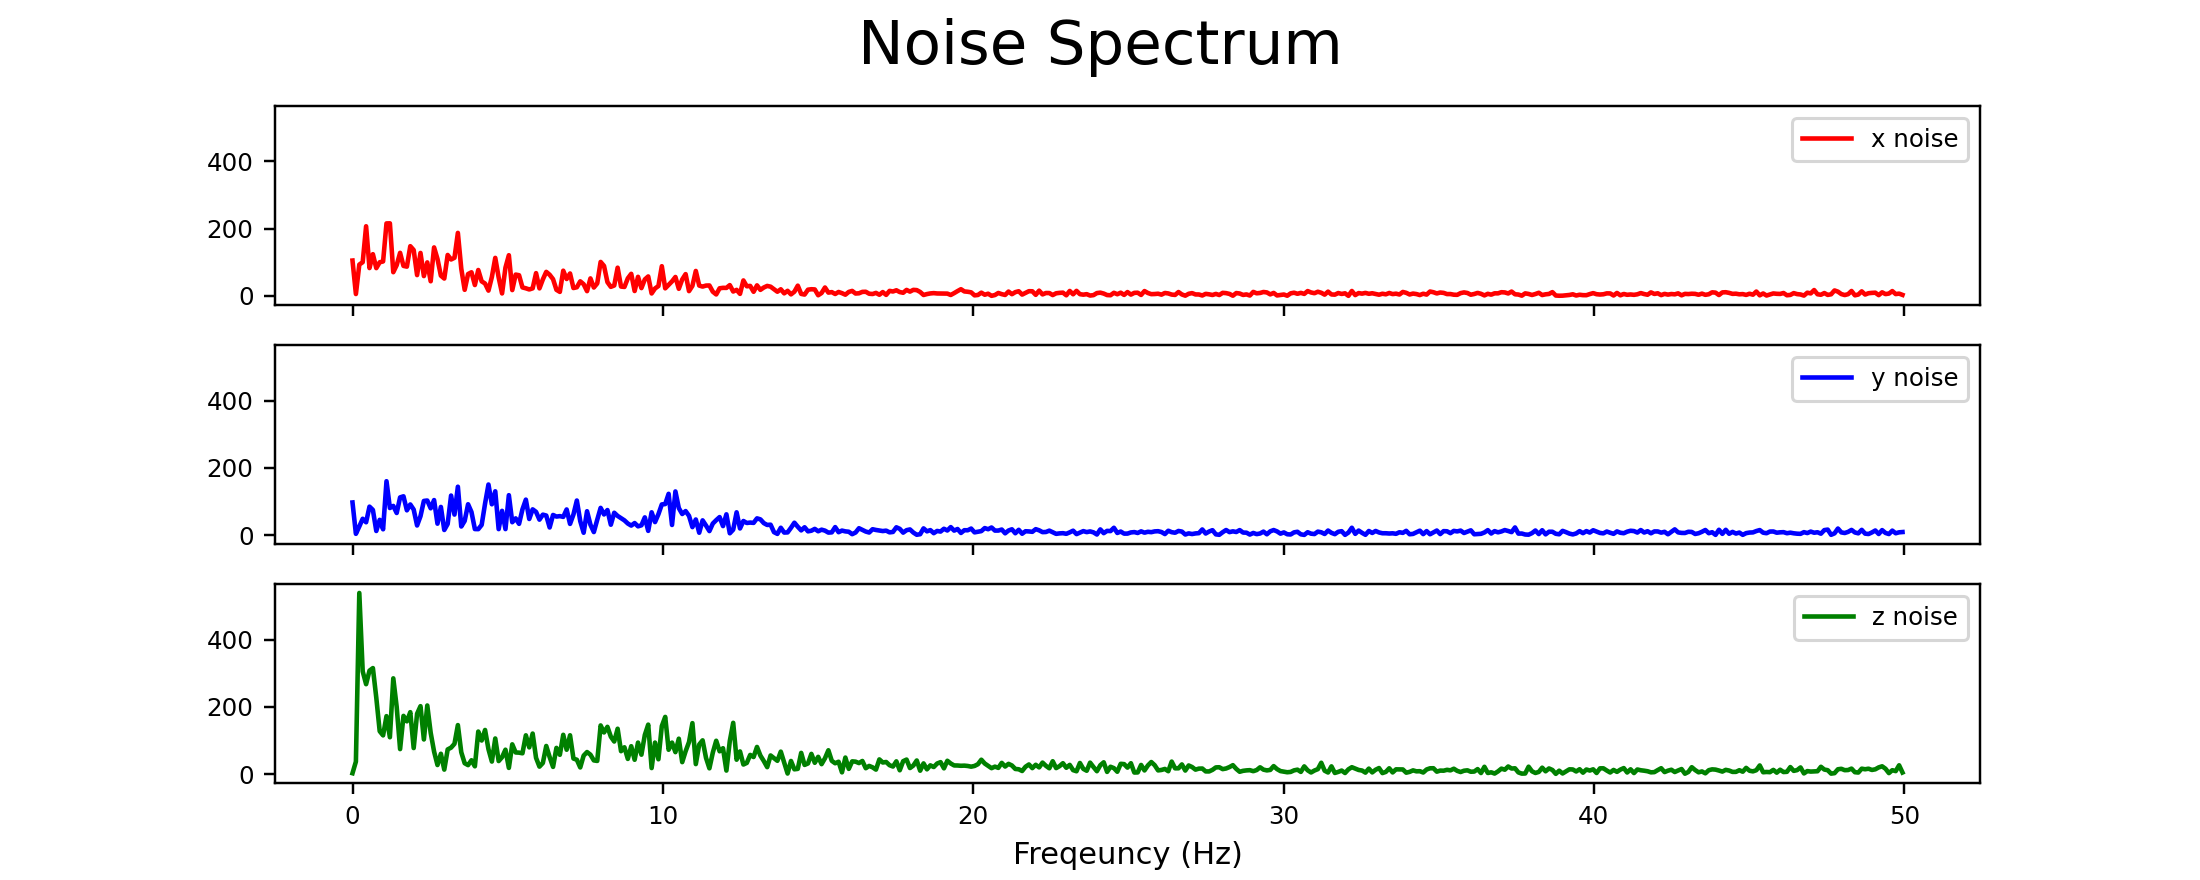

Text(0.5, 0, 'Freqeuncy (Hz)')

In [5]:
# # Notice drift in position

# Try to remove noise via Fourier analysis
    # Discrete Fourier Transform sample frequencies
freq = np.fft.rfftfreq(df['EARTH LINEAR ACCELERATION X'].size,d=dt)
# Compute the Fast Fourier Transform (FFT) of acceleration signals
fft_x = np.fft.rfft(df['EARTH LINEAR ACCELERATION X']) 
fft_y = np.fft.rfft(df['EARTH LINEAR ACCELERATION Y']) 
fft_z = np.fft.rfft(df['EARTH LINEAR ACCELERATION Z']) 

# Plot Frequency spectrum
plt.rcParams['figure.figsize'] = [10,4]
fig4,[ax1,ax2,ax3] = plt.subplots(3,1,sharex=True,sharey=True)
fig4.suptitle('Noise Spectrum',fontsize=20)
ax1.plot(freq,abs(fft_x),c='r',label='x noise')
ax1.legend()
ax2.plot(freq,abs(fft_y),c='b',label='y noise')
ax2.legend()
ax3.plot(freq,abs(fft_z),c='g',label='z noise')
ax3.legend()
ax3.set_xlabel('Freqeuncy (Hz)')


## Create a high-pass filter to attenuate low frequency noise

Lets design a high-pass filter like this:
Attenuate noise < 10 Hz in the X and Y axes by 10 dB (or multiply signal by 0.1)
Attenuate noise > 5 Hz and < 10 Hz in Z axis by 10 dB

<IPython.core.display.Javascript object>


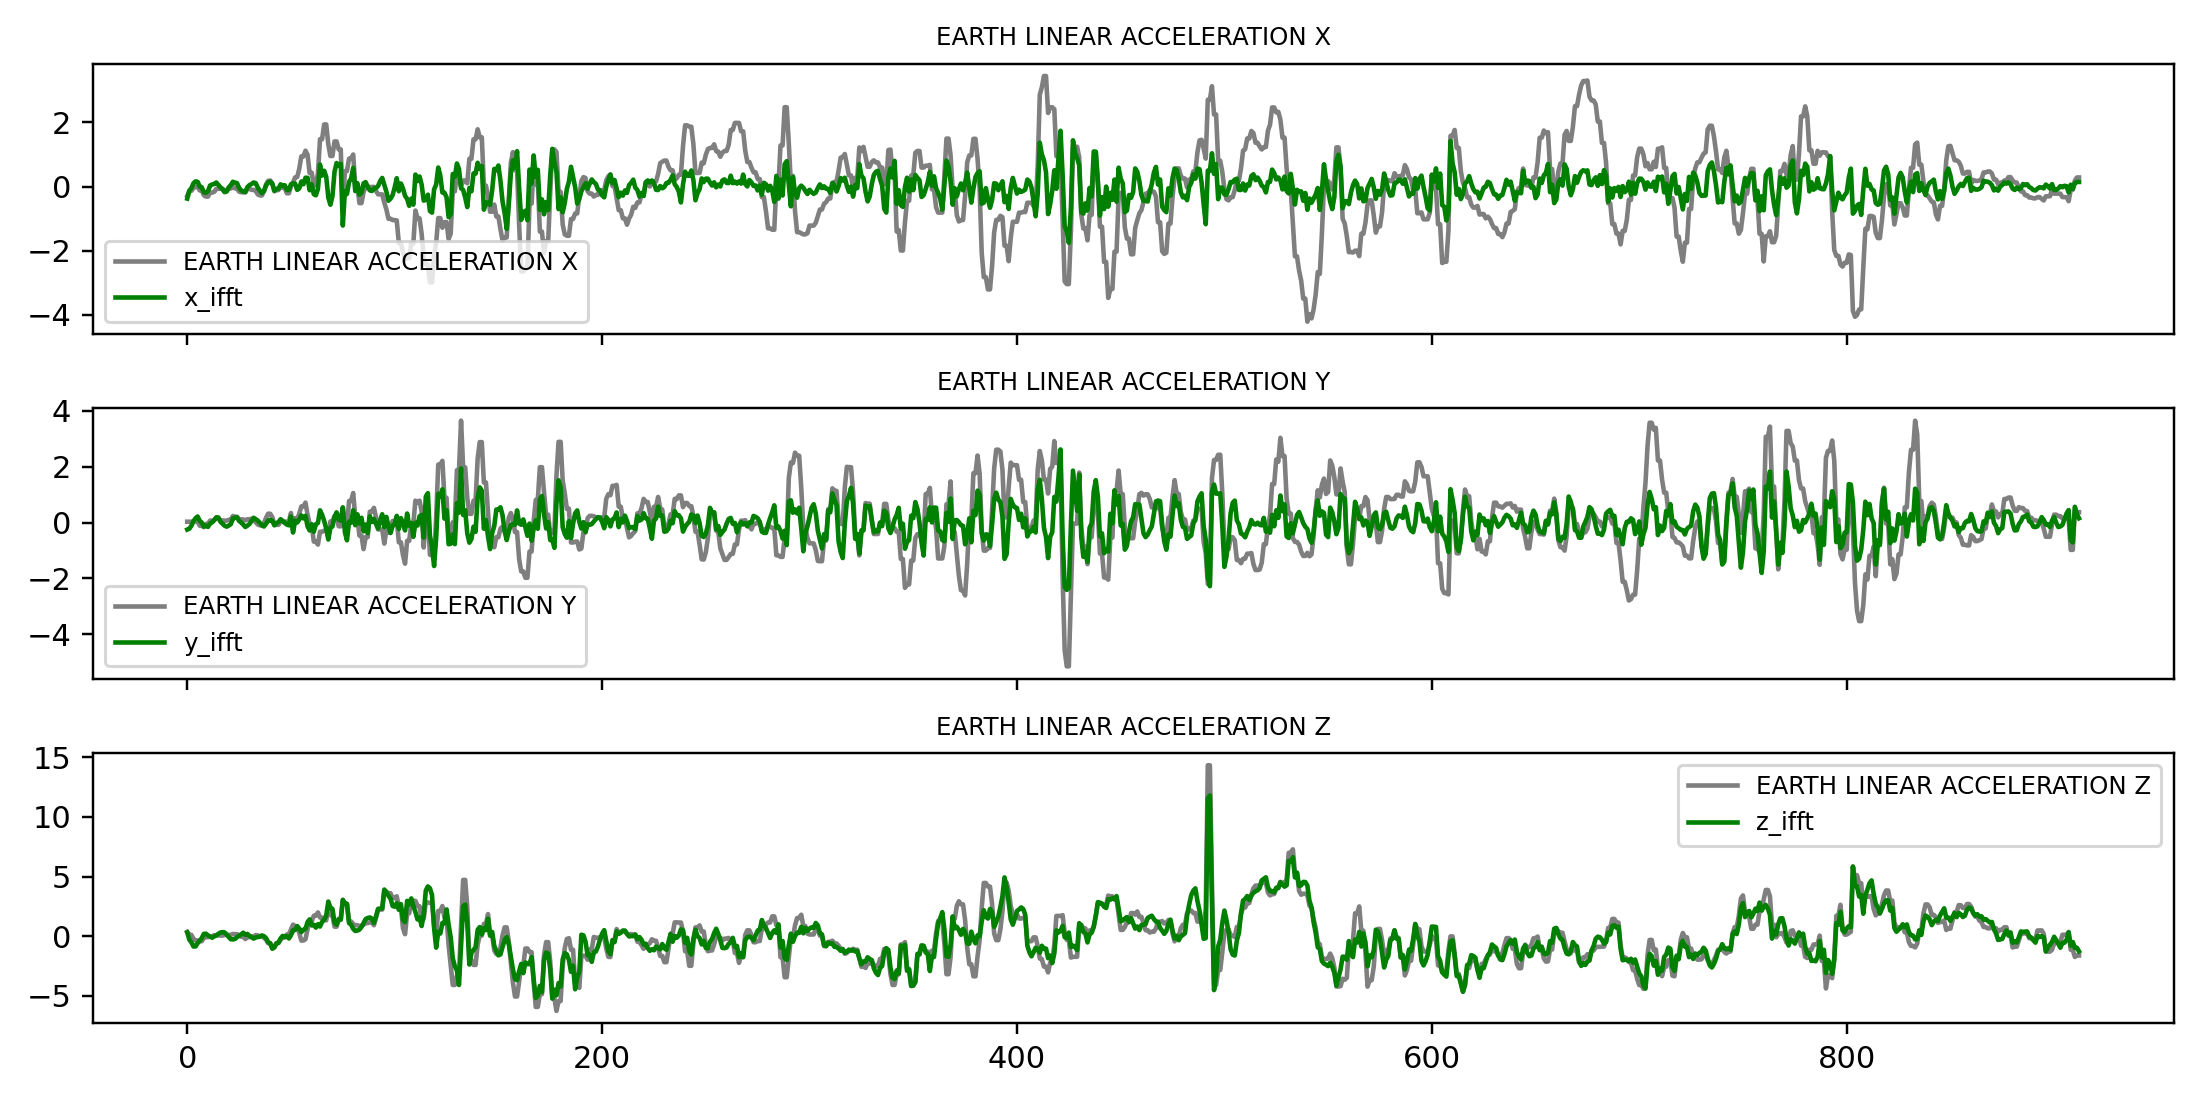

In [6]:
# Attenuate noise in X,Y below 1Hz by 0.2
atten_x_fft = np.where(freq < 10,fft_x * 0.1, fft_x) 
atten_y_fft = np.where(freq < 10,fft_y * 0.1, fft_y) 
atten_z_fft = np.where((freq > 5) & (freq < 10),fft_z * 0.1, fft_z) 
# Compute inverse of discrete Fourier Transform and save to dataframe
df['x_ifft'] = np.fft.irfft(atten_x_fft,n=df.shape[0])
df['y_ifft'] = np.fft.irfft(atten_y_fft,n=df.shape[0])
df['z_ifft'] = np.fft.irfft(atten_z_fft,n=df.shape[0])
# Plot new acceleration signals
cols_raw = ['EARTH LINEAR ACCELERATION X','EARTH LINEAR ACCELERATION Y',
            'EARTH LINEAR ACCELERATION Z']
cols_new = ['x_ifft','y_ifft','z_ifft']

plt.rcParams['figure.figsize'] = [10,5]

rawplot = df.plot(y=cols_raw,subplots=True,sharex=True,layout=(3,1),style='k',
                    title=cols_raw,alpha=0.5,fontsize=5)

df.plot(y=cols_new,subplots=True,ax=rawplot,style='g',fontsize=10)
plt.show()



## Make a 3D plot trajectory, and add x,y,z axis vectors to indicate phone pose.

Let’s compare the attenuated trajectory to the previous trajectory. The attenuated trajectory shows less than 1 m drift in the x,y plane! To finish this project, let’s add body axis arrows to the phone trajectory to indicate the phone’s orientation in space. This involves a reverse transformation from the earth frame to the body frame. We need to transform the unit earth x,y,z vectors ([1,0,0],[0,1,0],[0,0,1]) to body frame x,y,z unit vectors.

<IPython.core.display.Javascript object>


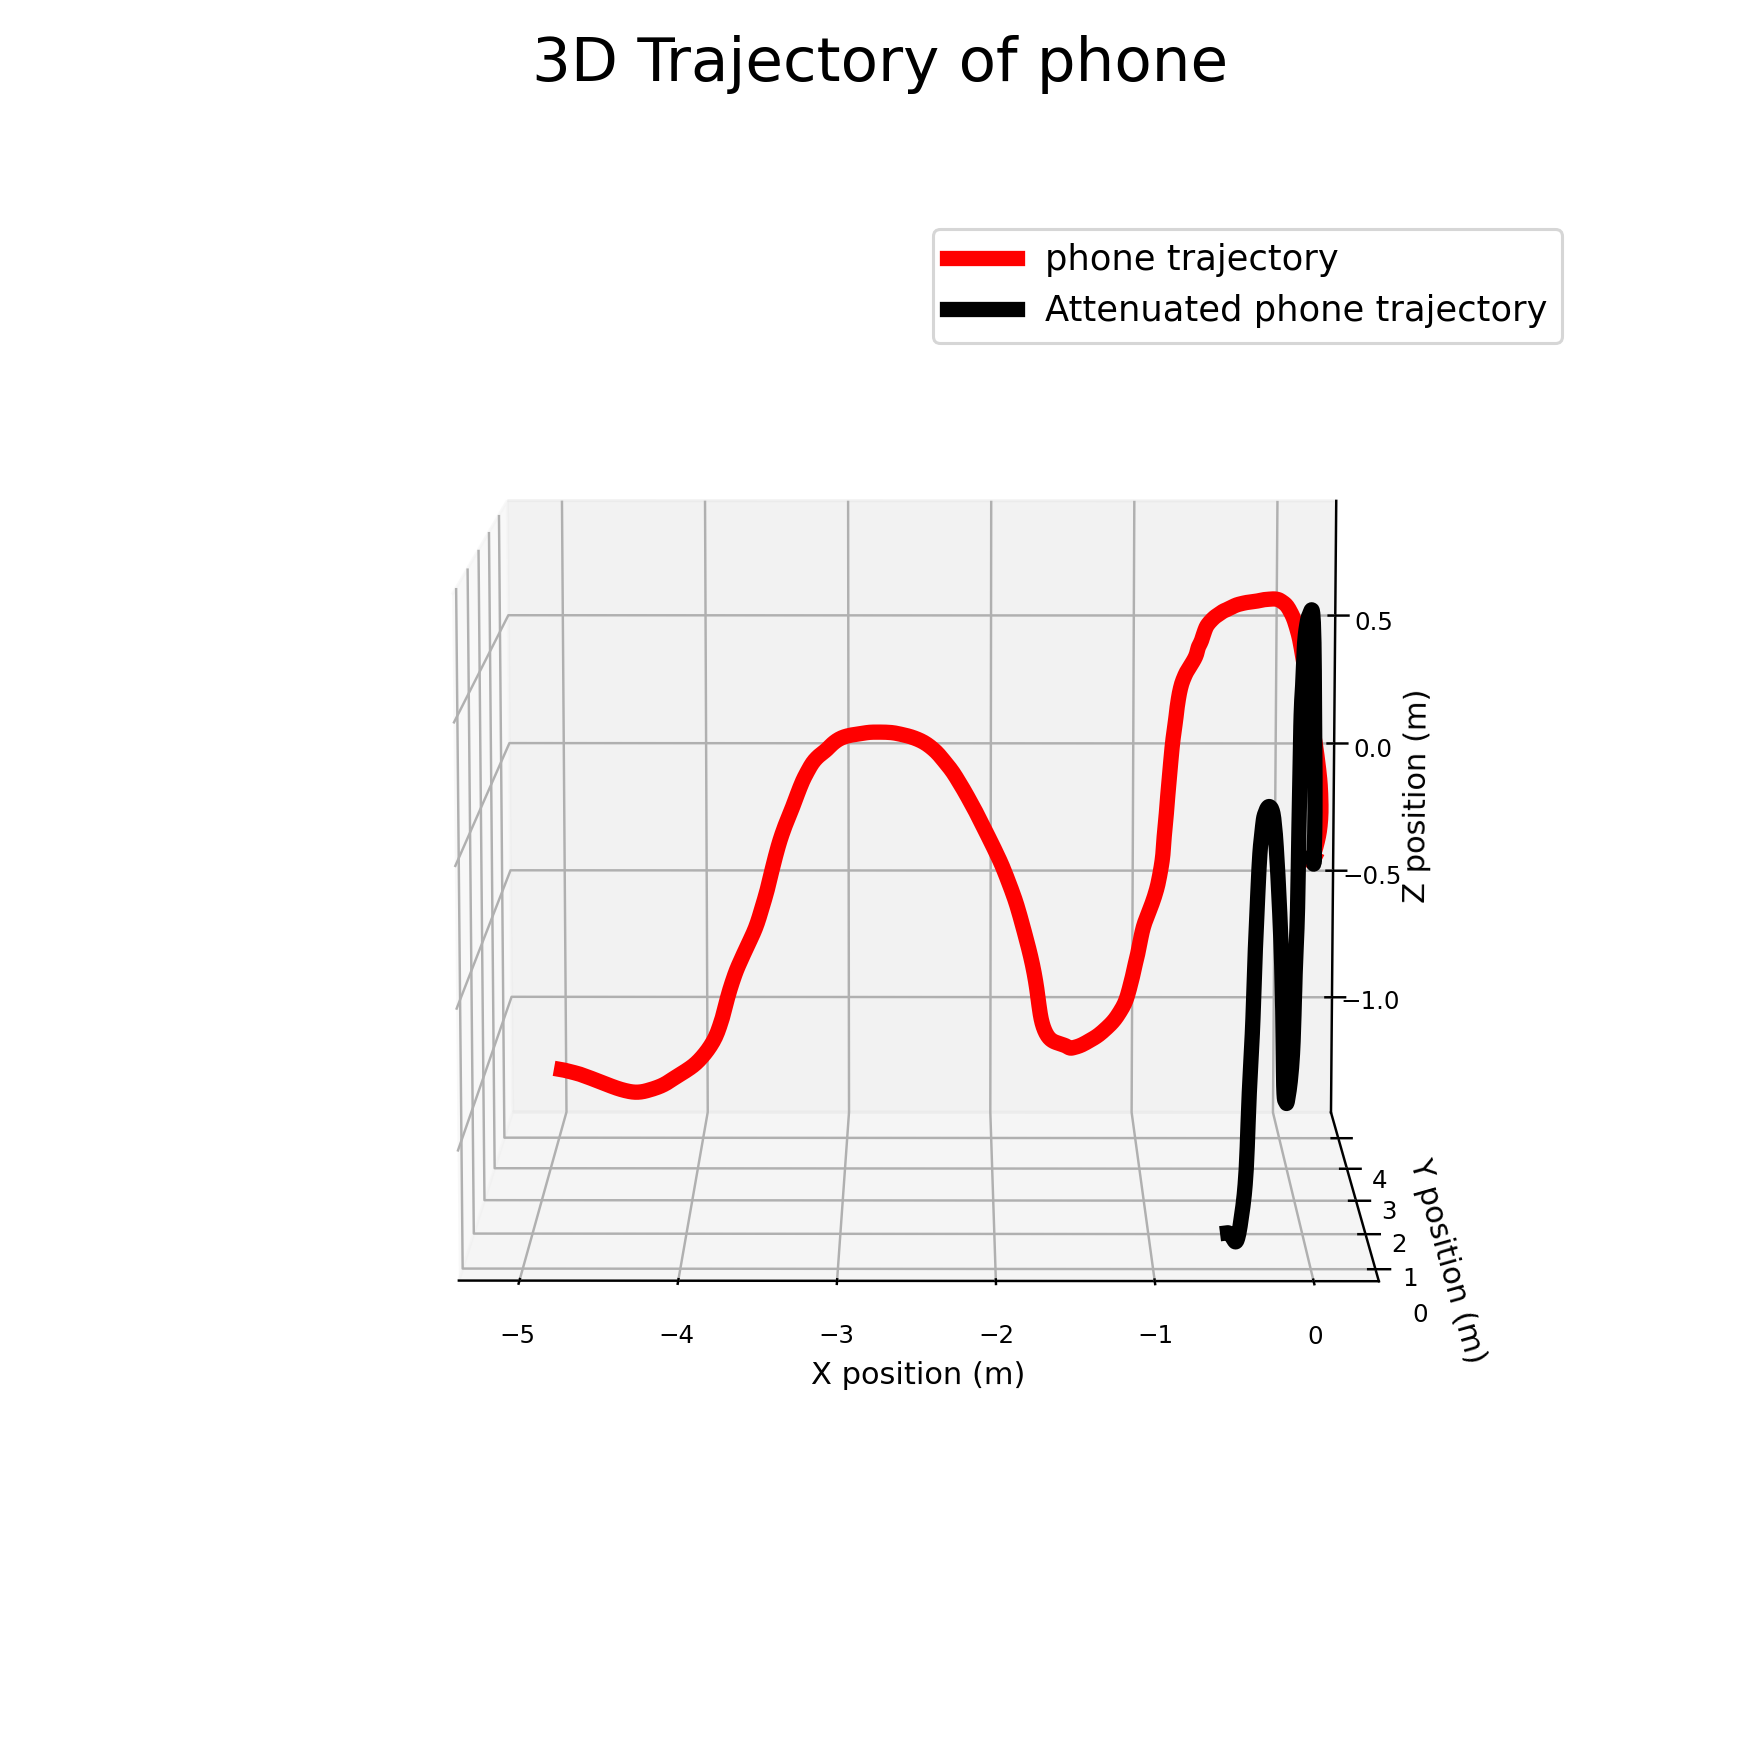

In [7]:
# Double integrate accelerations to calculate coordinate positions
x_atten = cumtrapz(cumtrapz(df['x_ifft'],dx=dt),dx=dt)
y_atten = cumtrapz(cumtrapz(df['y_ifft'],dx=dt),dx=dt)
z_atten = cumtrapz(cumtrapz(df['z_ifft'],dx=dt),dx=dt)
# Plot 3D Trajectory
plt.rcParams['figure.figsize'] = [8,8]
plt.tight_layout()
fig4,ax = plt.subplots()
fig4.suptitle('3D Trajectory of phone',fontsize=20)
ax = plt.axes(projection='3d')
ax.plot3D(x,y,z,c='red',lw=5,label='phone trajectory')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')

# Plot attenuated 3D Trajectory
ax.plot3D(x_atten,y_atten,z_atten,'k',lw=5,label='Attenuated phone trajectory')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')
ax.legend(fontsize='x-large')



## Quiver plot

Next we will build quiver plots to plot sets of arrows that indicate the phone’s [X,Y,Z] axes onto the trajectory. To make the plots easier to visualize, I will plot only one-tenth of the arrows (using [::10] slice notation).

<IPython.core.display.Javascript object>


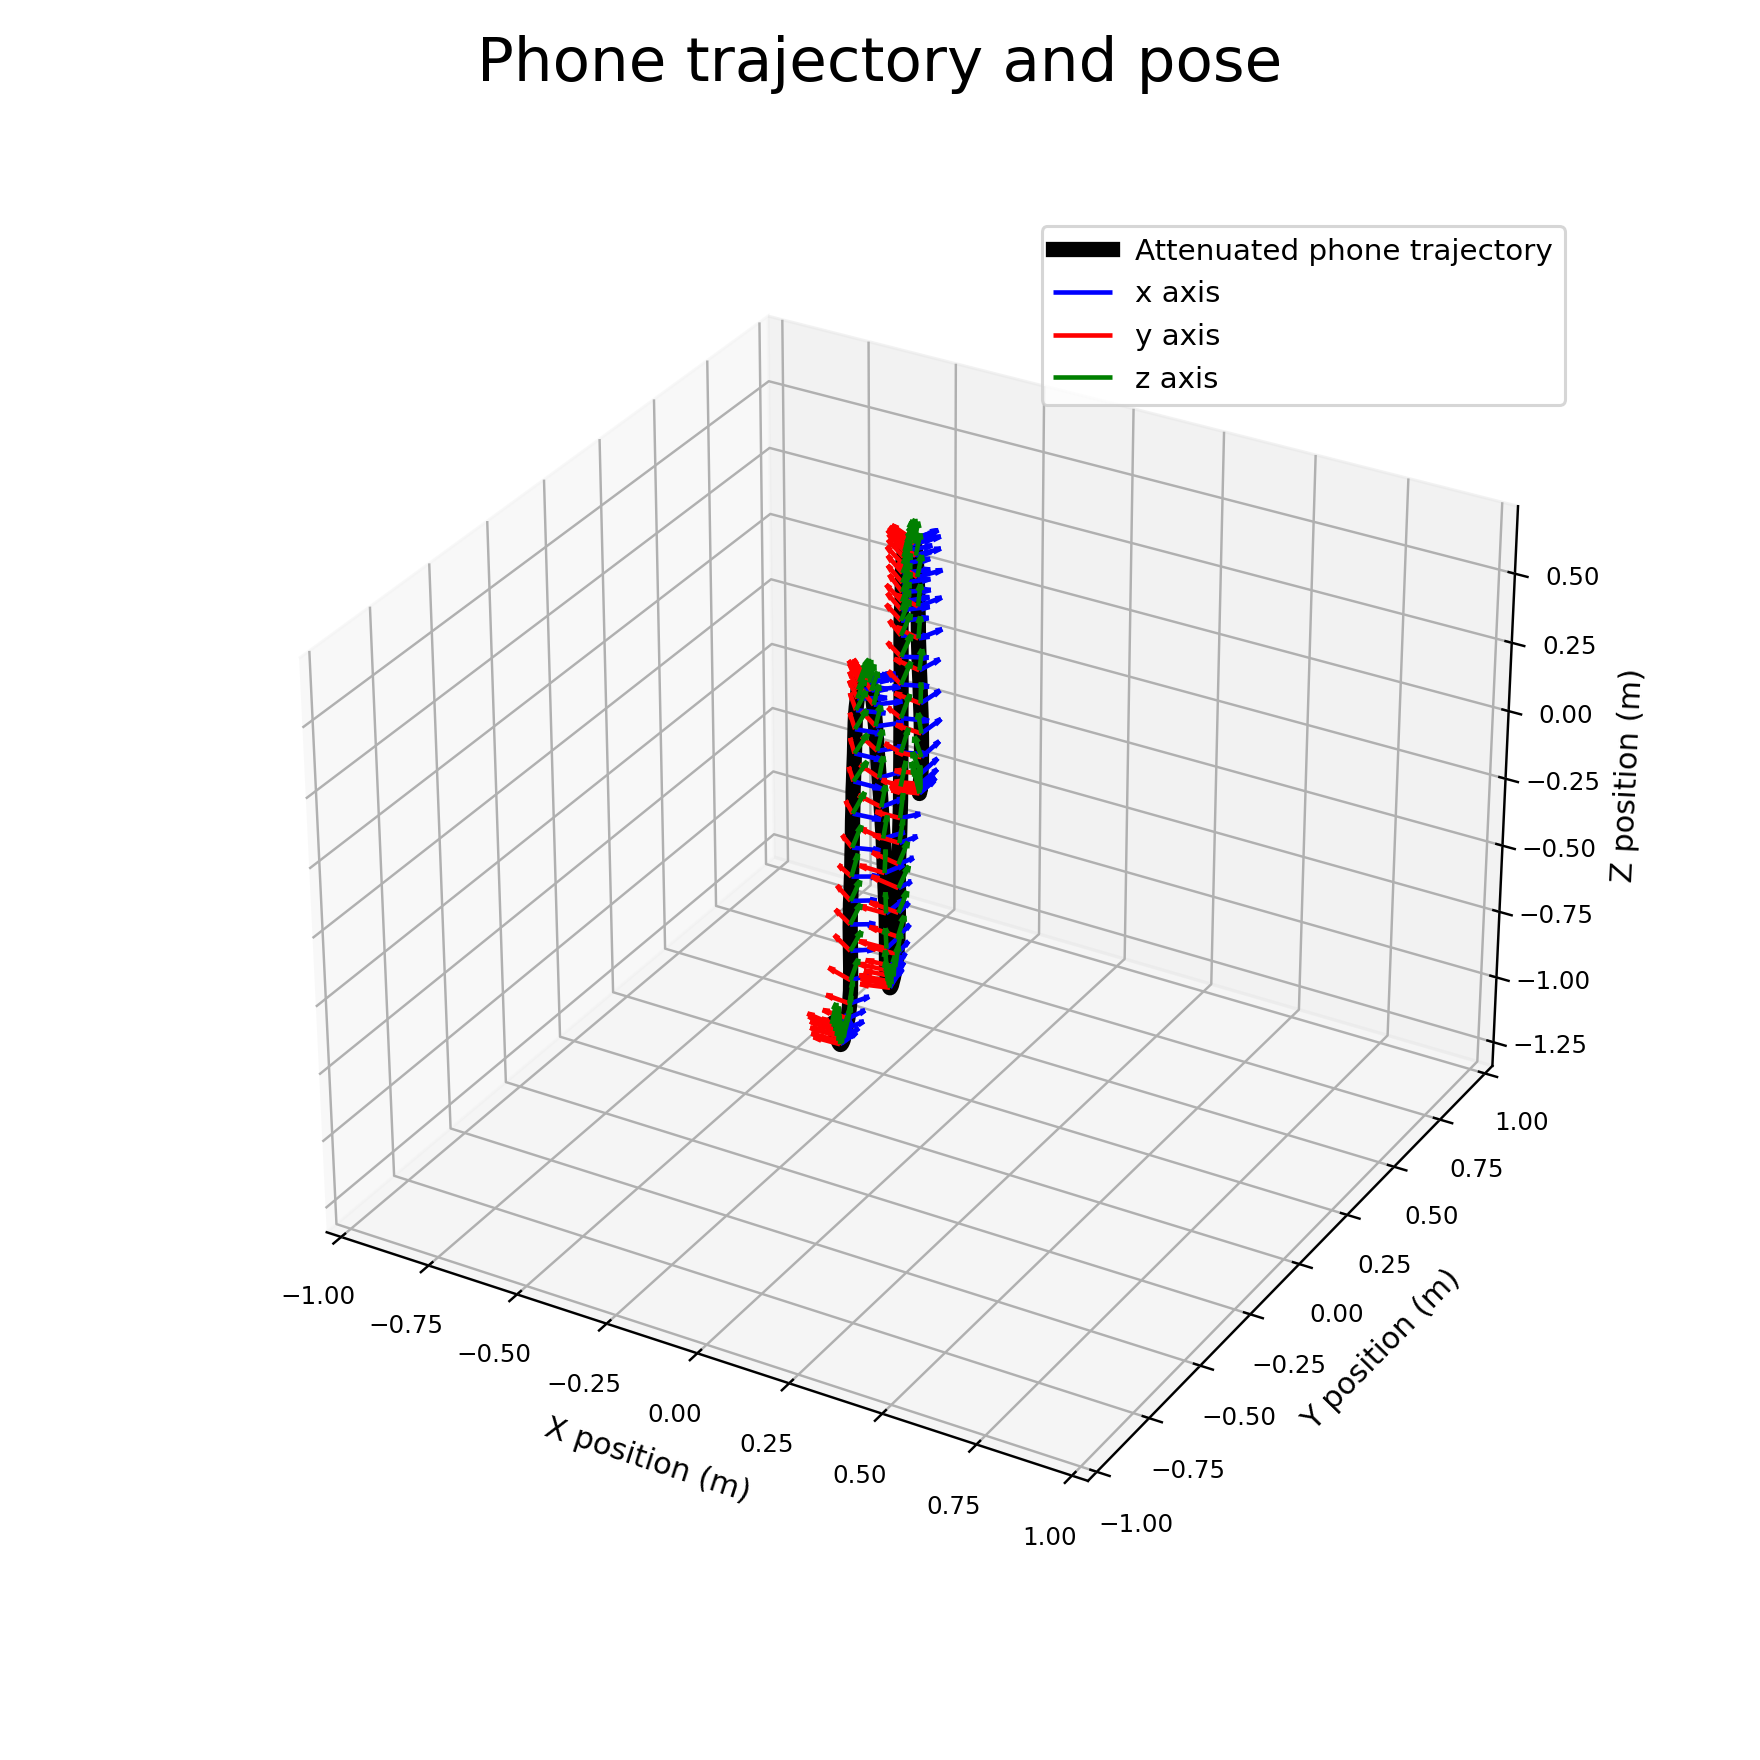

In [8]:
# Add XYZ axis arrows to indicate phone pose
    # Earth 3 axis vectors
earth_x = np.array([[1,0,0],]*len(x_atten)).T
earth_y = np.array([[0,1,0],]*len(x_atten)).T
earth_z = np.array([[0,0,1],]*len(x_atten)).T

# Initilize body Vectors
body_x = np.empty(earth_x.shape)
body_y = np.empty(earth_y.shape)
body_z = np.empty(earth_z.shape)

# Perform inverse frame transformations (body frame <-- earth frame) 
    # body_vectors = (RxRyRz)(earth_vectors)
for i in range(x.shape[0]):
    # use negative angles to reverse rotation
    body_x[:,i] = R_x(-pitch[i]) @ R_y(-roll[i]) @ R_z(-yaw[i]) @ earth_x[:,i]
    body_y[:,i] = R_x(-pitch[i]) @ R_y(-roll[i]) @ R_z(-yaw[i]) @ earth_y[:,i]
    body_z[:,i] = R_x(-pitch[i]) @ R_y(-roll[i]) @ R_z(-yaw[i]) @ earth_z[:,i]

# Set length of quiver arrows    
distance = np.sqrt(x_atten[-1]**2 + y_atten[-1]**2 + z_atten[-1]**2)
length = 0.05 * distance
# Plot x vectors
    # downsampling to every 10th arrow ([::10])

plt.rcParams['figure.figsize'] = [8,8]
fig6,ax4 = plt.subplots()
fig6.suptitle('Phone trajectory and pose',fontsize=20)
ax4 = plt.axes(projection='3d')
ax4.plot3D(x_atten,y_atten,z_atten,'k',lw=5,label='Attenuated phone trajectory')
ax4.quiver(x_atten[::10],y_atten[::10],z_atten[::10],
          body_x[0][::10],body_x[1][::10],body_x[2][::10],
          color='b',label = 'x axis',length = length)
# Plot y vectors
ax4.quiver(x_atten[::10],y_atten[::10],z_atten[::10],
          body_y[0][::10],body_y[1][::10],body_y[2][::10],
          color='r',label = 'y axis',length = length)
# Plot Z vectors
ax4.quiver(x_atten[::10],y_atten[::10],z_atten[::10],
          body_z[0][::10],body_z[1][::10],body_z[2][::10],
          color='g',label = 'z axis',length = length)
ax4.set_xlabel('X position (m)')
ax4.set_ylabel('Y position (m)')
ax4.set_zlabel('Z position (m)')
ax4.set_xlim(-1,1)
ax4.set_ylim(-1,1)
ax4.set_zlim(-1.3,0.7)
ax4.legend(fontsize='large')

plt.show()


## References

Exploring Data Acquisition and Trajectory Tracking with Android Devices and Python, Mack Raymond.